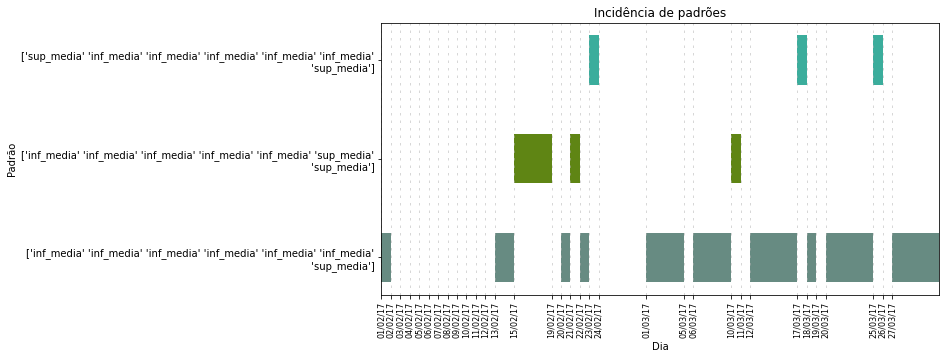

In [18]:
# SETUP

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

db_path = 'base_poluentes_internacoes_v6.csv'
plot_path = 'plt.jpg'
# db_path = input("Caminho para .csv:\n -> ")
# plot_path = input("\n\n plot output path:\n -> ")

df = pd.read_csv(db_path, sep=';')

# filtrando internações ALTA OU MEDIA
inter_filter = df[df['internacao'] != 'inf_media'].dropna()

# DETECÇÃO DE PADRÕES

db = {}  # irá armazenar os padrões em dias consecutivos
code = 0 # chave de acesso ao db
for index, row_i in inter_filter.iterrows():
    if index == 1:
        row_0 = row_i
        
    
    # salve os tempos iniciais e finais (b e f) do padrão
    b = datetime.datetime.strptime(row_0['Data'], '%d/%m/%y')
    f = datetime.datetime.strptime(row_i['Data'], '%d/%m/%y')
    diff = (f - b).days
    
    # padrão que não se repete em dias consecutivos
    pattern = [
        datetime.datetime.strftime(f, '%d/%m/%y'),
        datetime.datetime.strftime(f, '%d/%m/%y'),
        *row_i[1:]
    ]    
    
    # padrão que se repete em dias consecutivos
    if (row_i[1:].equals(row_0[1:])) and diff <= 1:
                    
        pattern = [
            datetime.datetime.strftime(b, '%d/%m/%y'),
            datetime.datetime.strftime(f, '%d/%m/%y'),
            *row_i[1:]
        ]
    else:
        code += 1
        
    # guarde o padrão no novo db
    if db.get(code, 0):
        db[code][1] = pattern[1] # apenas altera a data f caso já exista
    else:
        db[code] = pattern
    
    # passo
    row_0 = row_i
    
# transpor db para voltar ao formato convencional    
db = pd.DataFrame(db).transpose()    
new_col = list((inter_filter.columns).insert(1, 'f'))
new_col[0] = 'b'

# montar um DataFrame com os suportes de cada padrão encontrado em db
db = db.rename(columns={old:new for old, new in zip(db.columns, new_col)})
db_uniques = db.drop(columns=['b', 'f'])

supports = db.groupby(db_uniques.columns.tolist(),as_index=False).size()
supports['suporte'] = (supports['size'] / db.shape[0]).round(3)

##########################################################################
################### gravar a duração de cada padrão ######################

# conversores de variável temporal
to_datetime = lambda date: datetime.datetime.strptime(date, '%d/%m/%y') # data_string em datetime
to_days     = lambda days_datetime: days_datetime.days                  # datetime em dias_int

# conversões auxiliares das colunas temporais
b_datetime = db['b'].apply(to_datetime)
f_datetime = db['f'].apply(to_datetime)

# calcula a duração de cada padrão e grava em db
duration = (f_datetime - b_datetime).apply(to_days) + 1
db['lifespan'] = duration

# padrões únicos detectados em db
aux = db.iloc[:, 2:-1]
uniques = aux.drop_duplicates()

# variáveis axiliares para uso posterior
first_day  = b_datetime.iloc[0]
last_day   = f_datetime.iloc[-1]
time_range = (last_day - first_day).days # // 12


###########################################################################
############################ LINHA TEMPORAL ###############################
# conversor datetime para string
to_strftime = lambda date: date.strftime('%d/%m/%y')

# linha temporal de db (taxa de amostragem = 1 dia)
date_line = np.linspace(first_day.value, last_day.value, num=time_range)
date_line = pd.to_datetime(date_line)
date_line = date_line.to_pydatetime()
date_line = pd.Series(date_line).apply(to_strftime)
###########################################################################
###########################################################################
#-------------------------------------------------------------------------#
###########################################################################
######################### METADADOS DO GRÁFICO ############################
data   = {} # armazenar [padrão, início, duração, cor]
colors = {} # armazenar uma cor por padrão detectado

# gerar e gravar em COLORS uma cor aleatória por padrão detectado 
for row in uniques.values:
    colors[str(row)] = np.random.random(3)
    
# gravar em DATA os demais metadados 
for i, row in enumerate(db.values):

    b = row[0]                                      # data inicial
    b_encoded  = to_datetime(b).timetuple().tm_yday # convertida em dia do ano
    zero_point = first_day.timetuple().tm_yday      # marcador de referência (origem temporal)

    
    pattern = str(row[2:-1])         # padrão em string
    left    = b_encoded - zero_point # ponto inicial no gráfico
    width   = row[-1]                # largura da barra no gráfico (duração do padrão)
    color   = colors[pattern]        # cor da barra no gráfico
    
    # gravação
    data[i] = {'pattern': pattern,
               'left': left,
               'width': width,
               'color': color}
###########################################################################
###########################################################################
#-------------------------------------------------------------------------#
###########################################################################
################################# PLOT ####################################

# XTICKLABELS (RAW)
x = np.arange(date_line.shape[0])
last_event = 0 # var auxiliar para editar x

# ------------------------------------- #
fig, ax = plt.subplots(figsize=(10, 5))

for i, key in enumerate(data):
    
    # recupere os metadados gravados em DATA
    y = data[key]['pattern']
    width = data[key]['width']
    left = data[key]['left']
    color = data[key]['color']
    
    # horizontal bar plot
    ax.barh(y, width, height=0.5, left=left, color=color, linewidth=10)
    
    ########## edição de XTICKLABELS ###############
    if width > 1:                         # evento
        x[left+1: left+width] = '-1'      
    
    if (left - last_event > 1) & (i > 1): # não evento
        x[last_event+1: left] = '-1'      
    
    last_event = left+width               # update 


# recuperar tick labels
xticks       = x
xtickslabels = date_line.values

yticks       = np.arange(uniques.shape[0])
ytickslabels = np.arange(uniques.shape[0])

# plotar
# ax.set_yticks(np.arange(uniques.shape[0]))

ax.set_xticks(xticks)
ax.set_xticklabels(xtickslabels, rotation=90)
ax.tick_params(axis='x', labelsize=8)
plt.xlim(0, time_range+1)

#ax.set_yticks(yticks)
#ax.set_yticklabels(ytickslabels)

plt.xlabel("Dia")
plt.ylabel("Padrão")
plt.grid(which='major', axis='x', linestyle=(0, (5, 10)), linewidth=.5)
plt.title("Incidência de padrões")
plt.savefig(plot_path)

In [19]:
db

,b,f,"MP2,5",MP10,CO,SO2,NO2,O3,internacao,lifespan
1,01/02/17,01/02/17,inf_media,inf_media,inf_media,inf_media,inf_media,inf_media,sup_media,1
2,13/02/17,14/02/17,inf_media,inf_media,inf_media,inf_media,inf_media,inf_media,sup_media,2
3,15/02/17,18/02/17,inf_media,inf_media,inf_media,inf_media,inf_media,sup_media,sup_media,4
4,20/02/17,20/02/17,inf_media,inf_media,inf_media,inf_media,inf_media,inf_media,sup_media,1
5,21/02/17,21/02/17,inf_media,inf_media,inf_media,inf_media,inf_media,sup_media,sup_media,1
6,22/02/17,22/02/17,inf_media,inf_media,inf_media,inf_media,inf_media,inf_media,sup_media,1
7,23/02/17,23/02/17,sup_media,inf_media,inf_media,inf_media,inf_media,inf_media,sup_media,1
8,01/03/17,04/03/17,inf_media,inf_media,inf_media,inf_media,inf_media,inf_media,sup_media,4
9,06/03/17,09/03/17,inf_media,inf_media,inf_media,inf_media,inf_media,inf_media,sup_media,4
10,10/03/17,10/03/17,inf_media,inf_media,inf_media,inf_media,inf_media,sup_media,sup_media,1
